In [264]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms,models
from torch.utils.data import DataLoader,random_split,Subset,WeightedRandomSampler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
from PIL import Image,ImageFile

In [265]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [266]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [267]:
import kagglehub
path = kagglehub.dataset_download("andrewmvd/isic-2019")
print(path)

/kaggle/input/isic-2019


In [268]:
training_csv=pd.read_csv(f"/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv")

In [269]:
training_csv.head(10)

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,ISIC_0000006,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,ISIC_0000007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,ISIC_0000008,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,ISIC_0000009,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,ISIC_0000010,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [270]:
training_csv.tail(10)

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
25321,ISIC_0073240,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25322,ISIC_0073241,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25323,ISIC_0073244,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25324,ISIC_0073245,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25325,ISIC_0073246,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25330,ISIC_0073254,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [271]:
training_csv.shape

(25331, 10)

In [272]:
training_csv["UNK"].sum() #All the labels are known

np.float64(0.0)

In [273]:
images_dirpath="/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input"

In [274]:
!ls /kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input | head

ATTRIBUTION.txt
ISIC_0000000.jpg
ISIC_0000001.jpg
ISIC_0000002.jpg
ISIC_0000003.jpg
ISIC_0000004.jpg
ISIC_0000006.jpg
ISIC_0000007.jpg
ISIC_0000008.jpg
ISIC_0000009.jpg
ls: write error: Broken pipe


In [275]:
# plt.imshow(plt.imread(f'{images_dirpath}/ISIC_0000009.jpg'))
# plt.show()

In [276]:
sample_image=plt.imread(f'{images_dirpath}/ISIC_0000006.jpg')
print(sample_image.shape)

(767, 1022, 3)


In [277]:
# Organizing the Data
!path="/kaggle/input/isic-2019"
!ls $path

ISIC_2019_Training_GroundTruth.csv  ISIC_2019_Training_Metadata.csv
ISIC_2019_Training_Input


In [278]:
if not os.path.isdir("Image_Classifiers"):
  os.mkdir("Image_Classifiers")

In [279]:
idx=0
for image_name in training_csv["image"]:
  class_dir_path="Image_Classifiers"
  for cancer_type in range(1,9):
    if training_csv.iloc[idx,cancer_type].astype('int') == 1:
      class_dir_path=os.path.join(class_dir_path,f"class_label_{cancer_type}")
  if not os.path.isdir(class_dir_path):
    os.mkdir(class_dir_path)
  image_path=os.path.join(class_dir_path,f"{image_name}.jpg")
  orig_image_path=f"{images_dirpath}/{image_name}.jpg"
  if not os.path.isfile(image_path):
    shutil.copy(orig_image_path,image_path)
  idx+=1

In [280]:
corrupted_files=[]
fraction_classes=np.zeros(8)
i=0
for sub_folder in os.listdir("Image_Classifiers"):
  for img in os.listdir(os.path.join("Image_Classifiers",sub_folder)):
    i+=1
    img_path=os.path.join("Image_Classifiers",sub_folder,img)
    try:
      with Image.open(img_path) as checking_img:
        checking_img.verify()
    except:
      corrupted_files.append(img_path)
  print(os.path.join("Image_Classifiers",sub_folder),i)
  # print(sub_folder.split('_')[2])
  fraction_classes[int(sub_folder.split('_')[2])-1]=i
  i=0
fraction_classes

Image_Classifiers/class_label_4 867
Image_Classifiers/class_label_2 12875
Image_Classifiers/class_label_8 628
Image_Classifiers/class_label_1 4522
Image_Classifiers/class_label_5 2624
Image_Classifiers/class_label_7 253
Image_Classifiers/class_label_3 3323
Image_Classifiers/class_label_6 239


array([ 4522., 12875.,  3323.,   867.,  2624.,   239.,   253.,   628.])

In [281]:
fraction_classes/=np.sum(fraction_classes)

In [282]:
print(corrupted_files)
for file in corrupted_files:
  os.remove(file)

[]


In [283]:
dataset = datasets.ImageFolder("Image_Classifiers")
total_size=len(dataset)
train_batch_size=int(0.8*total_size)
test_batch_size=int(0.05*total_size)

train_idx, test_idx,_ = random_split(
    range(total_size),
    [train_batch_size, test_batch_size, total_size-train_batch_size-test_batch_size]
    )

input_img_size=96

train_transform = transforms.Compose([
    transforms.Resize((input_img_size,input_img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((input_img_size,input_img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

visual_transform = transforms.Compose([
    transforms.Resize((input_img_size,input_img_size)),
    transforms.ToTensor()
])

train_dataset = Subset(
    datasets.ImageFolder("Image_Classifiers", transform=train_transform),
    train_idx
)

test_dataset = Subset(
    datasets.ImageFolder("Image_Classifiers", transform=test_transform),
    test_idx
)

visual_test_dataset = Subset(
    datasets.ImageFolder("Image_Classifiers", transform=visual_transform),
    test_idx
)

targets = np.array(train_dataset.dataset.targets)[train_dataset.indices]
class_counts = np.bincount(targets)
class_weights = 1.0 / class_counts

sample_weights = class_weights[targets]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)
# sampler=WeightesRandomSampler(weights=)
train_loader=DataLoader(train_dataset,batch_size=64,sampler=sampler)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=True)
visual_test_loader=DataLoader(visual_test_dataset,batch_size=24,shuffle=True)


In [284]:
total_size

25331

In [285]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
def visualize(visualizer_loader,n=5):
    x, y = next(iter(visualizer_loader))
    x, y = x.to(device), y.to(device)
    plt.figure(figsize=(12,12))
    for i in range(n):
        plt.subplot(n//4+1, 4, i+1)
        plt.imshow(x[i].cpu().squeeze().permute(1,2,0))
        plt.axis('off')
    plt.show()
# visualize(visual_test_loader,16)

In [286]:
def train_model(model,train_loader,test_loader,optimizer,loss_fn,train_accuracy,test_accuracy,epochs=5):
  for epoch in range(epochs):
    model.train()
    total_loss=0
    total=0
    correct=0
    step=0
    for x,y in train_loader:
      step+=1
      x,y=x.to(device),y.to(device)
      optimizer.zero_grad()
      logits=model(x)
      loss=loss_fn(logits,y)
      loss.backward()
      optimizer.step()
      total_loss+=loss.item()
      pred=logits.argmax(dim=1)
      correct+=(pred==y).sum().item()
      total+=y.size(0)
      if step%20==0:
          print(f"Step {step} : Intermediate Accuracy = {100*correct/total :.2f}")
    print(f"Epoch {epoch+1}")
    print(f"Loss : {total_loss:.4f}")
    print("Training Accuracy")
    train_accuracy.append(100*correct/total)
    print(f"Accuracy: {100*correct/total :.2f}")
    print("Testing Accuracy")
    test_accuracy.append(test_model(model,test_loader))
    # train_accuracy.append(test_model(model,train_loader))

def test_model(model,test_loader):
  model.eval()
  correct=0
  total=0
  with torch.no_grad():
    for x,y in test_loader:
      x,y=x.to(device),y.to(device)
      logits=model(x)
      pred=logits.argmax(dim=1)
      correct+=(pred==y).sum().item()
      total+=y.size(0)
  print(f"Accuracy: {100*correct/total :.2f}")
  return 100*correct/total

In [287]:
class CNN_Model(nn.Module):
  def __init__(self):
    super(CNN_Model,self).__init__()

  def forward(self):
    pass

In [288]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return nn.functional.relu(self.fn(x) + x)
def conv_block(input_channel,output_channel):
    return nn.Sequential(
        nn.Conv2d(input_channel, output_channel, 3, padding=1),
        nn.BatchNorm2d(output_channel),
        nn.ReLU(),
        nn.Conv2d(output_channel, output_channel, 3, padding=1),
        nn.BatchNorm2d(output_channel)
    )

In [289]:
# model=CNN_Model()
#Image Dimensions 64*64
model=nn.Sequential(
    nn.Conv2d(3,32,3,padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32,32,3,padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2,2),
    # nn.Dropout(0.3),
    nn.Conv2d(32,64,3,padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64,64,3,padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2,2),
    # nn.Dropout(0.3),
    nn.Conv2d(64,128,3,padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.Conv2d(128,128,3,padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(2,2),
    # nn.Dropout(0.4),
    nn.Flatten(),
    nn.Linear(12*12*128,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    # nn.Dropout(0.3),
    nn.Linear(128,8)
)
model=model.to(device)
optimizer=optim.Adam(model.parameters(),lr=0.0003,weight_decay=1e-4)
loss_fn=nn.CrossEntropyLoss()
train_accuracy=[]
test_accuracy=[]
# test_model(model,test_loader)
train_model(model,train_loader,test_loader,optimizer,loss_fn,train_accuracy,test_accuracy,8)
test_model(model,test_loader)


Step 20 : Intermediate Accuracy = 31.41
Step 40 : Intermediate Accuracy = 36.02
Step 60 : Intermediate Accuracy = 38.59
Step 80 : Intermediate Accuracy = 40.37
Step 100 : Intermediate Accuracy = 41.84
Step 120 : Intermediate Accuracy = 43.57
Step 140 : Intermediate Accuracy = 45.20
Step 160 : Intermediate Accuracy = 46.39
Step 180 : Intermediate Accuracy = 47.44
Step 200 : Intermediate Accuracy = 48.57
Step 220 : Intermediate Accuracy = 49.55
Step 240 : Intermediate Accuracy = 50.65
Step 260 : Intermediate Accuracy = 51.59
Step 280 : Intermediate Accuracy = 52.46
Step 300 : Intermediate Accuracy = 53.46
Epoch 1
Loss : 404.3758
Training Accuracy
Accuracy: 54.40
Testing Accuracy
Accuracy: 53.48
Step 20 : Intermediate Accuracy = 69.22
Step 40 : Intermediate Accuracy = 69.65
Step 60 : Intermediate Accuracy = 69.82
Step 80 : Intermediate Accuracy = 70.74
Step 100 : Intermediate Accuracy = 70.69
Step 120 : Intermediate Accuracy = 71.22
Step 140 : Intermediate Accuracy = 71.32
Step 160 : Inte

64.13902053712481

In [290]:
model1=model
train_accuracy_1=train_accuracy
test_accuracy_1=test_accuracy
test_model(model1,test_loader)

Accuracy: 64.14


64.13902053712481

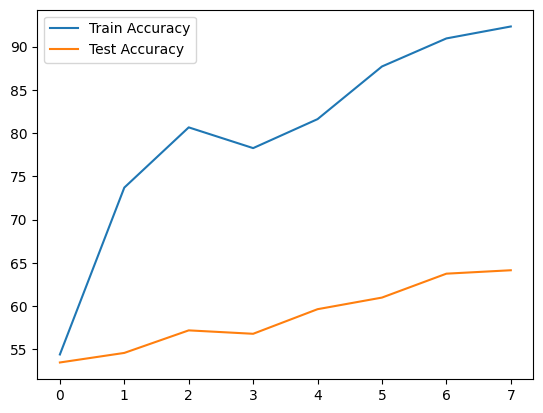

In [291]:
plt.plot(train_accuracy_1,label="Train Accuracy")
plt.plot(test_accuracy_1,label="Test Accuracy")
plt.legend()
plt.show()

In [292]:
# model=CNN_Model()
#Image Dimensions 64*64
model=nn.Sequential(
    nn.Conv2d(3,32,3,padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32,32,3,padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2,2),
    nn.Dropout(0.3),
    nn.Conv2d(32,64,3,padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64,64,3,padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2,2),
    nn.Dropout(0.3),
    nn.Conv2d(64,128,3,padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.Conv2d(128,128,3,padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(2,2),
    nn.Dropout(0.3),
    nn.Flatten(),
    nn.Linear(12*12*128,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.3),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(0.1),
    nn.Linear(128,8)
)
model=model.to(device)
optimizer=optim.Adam(model.parameters(),lr=0.0003,weight_decay=1e-4)
loss_fn=nn.CrossEntropyLoss()
train_accuracy=[]
test_accuracy=[]
# test_model(model,test_loader)
train_model(model,train_loader,test_loader,optimizer,loss_fn,train_accuracy,test_accuracy,8)
test_model(model,test_loader)


Step 20 : Intermediate Accuracy = 27.19
Step 40 : Intermediate Accuracy = 30.27
Step 60 : Intermediate Accuracy = 32.84
Step 80 : Intermediate Accuracy = 34.63
Step 100 : Intermediate Accuracy = 36.14
Step 120 : Intermediate Accuracy = 36.89
Step 140 : Intermediate Accuracy = 38.06
Step 160 : Intermediate Accuracy = 38.90
Step 180 : Intermediate Accuracy = 39.84
Step 200 : Intermediate Accuracy = 40.33
Step 220 : Intermediate Accuracy = 41.20
Step 240 : Intermediate Accuracy = 41.91
Step 260 : Intermediate Accuracy = 42.38
Step 280 : Intermediate Accuracy = 43.06
Step 300 : Intermediate Accuracy = 43.65
Epoch 1
Loss : 477.5817
Training Accuracy
Accuracy: 44.04
Testing Accuracy
Accuracy: 34.36
Step 20 : Intermediate Accuracy = 50.00
Step 40 : Intermediate Accuracy = 49.92
Step 60 : Intermediate Accuracy = 50.78
Step 80 : Intermediate Accuracy = 51.95
Step 100 : Intermediate Accuracy = 52.14
Step 120 : Intermediate Accuracy = 52.99
Step 140 : Intermediate Accuracy = 53.66
Step 160 : Inte

59.47867298578199

In [293]:
model2=model
train_accuracy_2=train_accuracy
test_accuracy_2=test_accuracy
test_model(model2,test_loader)

Accuracy: 59.48


59.47867298578199

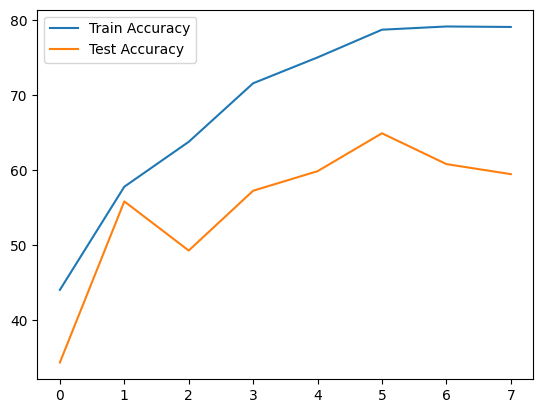

In [294]:
plt.plot(train_accuracy_2,label="Train Accuracy")
plt.plot(test_accuracy_2,label="Test Accuracy")
plt.legend()
plt.show()

In [295]:
# model=CNN_Model()
#Image Dimensions 64*64
model=nn.Sequential(
    nn.Conv2d(3,32,3,padding=1),
    Residual(conv_block(32,32)),
    nn.MaxPool2d(2,2),
    # nn.Dropout(0.3),
    nn.Conv2d(32,64,3,padding=1),
    Residual(conv_block(64,64)),
    nn.MaxPool2d(2,2),
    # nn.Dropout(0.3),
    # Residual(conv_block(128,128)),
    nn.MaxPool2d(2,2),
    # nn.Dropout(0.3),
    nn.Flatten(),
    nn.Linear(12*12*64,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128,8)
)
model=model.to(device)
optimizer=optim.Adam(model.parameters(),lr=0.0003,weight_decay=1e-4)
loss_fn=nn.CrossEntropyLoss()
train_accuracy=[]
test_accuracy=[]
# test_model(model,test_loader)
train_model(model,train_loader,test_loader,optimizer,loss_fn,train_accuracy,test_accuracy,8)
test_model(model,test_loader)


Step 20 : Intermediate Accuracy = 26.25
Step 40 : Intermediate Accuracy = 30.94
Step 60 : Intermediate Accuracy = 33.62
Step 80 : Intermediate Accuracy = 36.27
Step 100 : Intermediate Accuracy = 38.53
Step 120 : Intermediate Accuracy = 40.09
Step 140 : Intermediate Accuracy = 41.19
Step 160 : Intermediate Accuracy = 42.44
Step 180 : Intermediate Accuracy = 43.73
Step 200 : Intermediate Accuracy = 44.82
Step 220 : Intermediate Accuracy = 45.85
Step 240 : Intermediate Accuracy = 46.64
Step 260 : Intermediate Accuracy = 47.57
Step 280 : Intermediate Accuracy = 48.36
Step 300 : Intermediate Accuracy = 49.11
Epoch 1
Loss : 442.1936
Training Accuracy
Accuracy: 49.82
Testing Accuracy
Accuracy: 52.45
Step 20 : Intermediate Accuracy = 62.34
Step 40 : Intermediate Accuracy = 63.05
Step 60 : Intermediate Accuracy = 63.85
Step 80 : Intermediate Accuracy = 63.89
Step 100 : Intermediate Accuracy = 64.09
Step 120 : Intermediate Accuracy = 64.79
Step 140 : Intermediate Accuracy = 65.46
Step 160 : Inte

65.48183254344391

In [296]:
model3=model
train_accuracy_3=train_accuracy
test_accuracy_3=test_accuracy
test_model(model3,test_loader)

Accuracy: 65.48


65.48183254344391

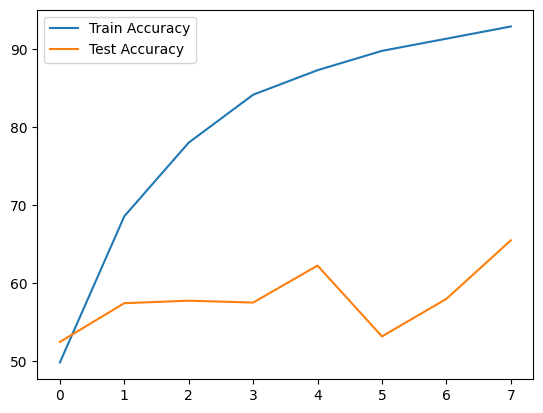

In [297]:
plt.plot(train_accuracy_3,label="Train Accuracy")
plt.plot(test_accuracy_3,label="Test Accuracy")
plt.legend()
plt.show()

In [298]:
# model=CNN_Model()
#Image Dimensions 64*64
model=nn.Sequential(
    nn.Conv2d(3,32,3,padding=1),
    Residual(conv_block(32,32)),
    nn.MaxPool2d(2,2),
    nn.Dropout(0.3),
    nn.Conv2d(32,64,3,padding=1),
    Residual(conv_block(64,64)),
    nn.MaxPool2d(2,2),
    nn.Dropout(0.3),
    # Residual(conv_block(128,128)),
    nn.MaxPool2d(2,2),
    nn.Dropout(0.3),
    nn.Flatten(),
    nn.Linear(12*12*64,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.3),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(0.1),
    nn.Linear(128,8)
)
model=model.to(device)
optimizer=optim.Adam(model.parameters(),lr=0.0003,weight_decay=1e-4)
loss_fn=nn.CrossEntropyLoss()
train_accuracy=[]
test_accuracy=[]
# test_model(model,test_loader)
train_model(model,train_loader,test_loader,optimizer,loss_fn,train_accuracy,test_accuracy,8)
test_model(model,test_loader)


Step 20 : Intermediate Accuracy = 22.11
Step 40 : Intermediate Accuracy = 26.80
Step 60 : Intermediate Accuracy = 29.48
Step 80 : Intermediate Accuracy = 30.96
Step 100 : Intermediate Accuracy = 32.45
Step 120 : Intermediate Accuracy = 33.14
Step 140 : Intermediate Accuracy = 33.88
Step 160 : Intermediate Accuracy = 34.24
Step 180 : Intermediate Accuracy = 34.72
Step 200 : Intermediate Accuracy = 35.55
Step 220 : Intermediate Accuracy = 36.31
Step 240 : Intermediate Accuracy = 36.86
Step 260 : Intermediate Accuracy = 37.60
Step 280 : Intermediate Accuracy = 38.06
Step 300 : Intermediate Accuracy = 38.40
Epoch 1
Loss : 518.2948
Training Accuracy
Accuracy: 38.56
Testing Accuracy
Accuracy: 39.89
Step 20 : Intermediate Accuracy = 45.70
Step 40 : Intermediate Accuracy = 45.43
Step 60 : Intermediate Accuracy = 46.09
Step 80 : Intermediate Accuracy = 46.48
Step 100 : Intermediate Accuracy = 47.06
Step 120 : Intermediate Accuracy = 47.51
Step 140 : Intermediate Accuracy = 47.77
Step 160 : Inte

57.97788309636651

In [299]:
model4=model
train_accuracy_4=train_accuracy
test_accuracy_4=test_accuracy
test_model(model4,test_loader)

Accuracy: 57.98


57.97788309636651

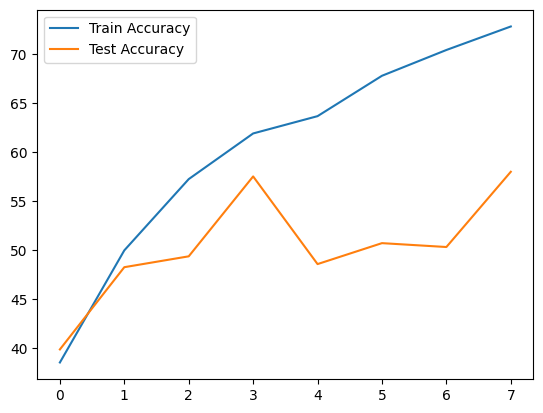

In [300]:
plt.plot(train_accuracy_4,label="Train Accuracy")
plt.plot(test_accuracy_4,label="Test Accuracy")
plt.legend()
plt.show()

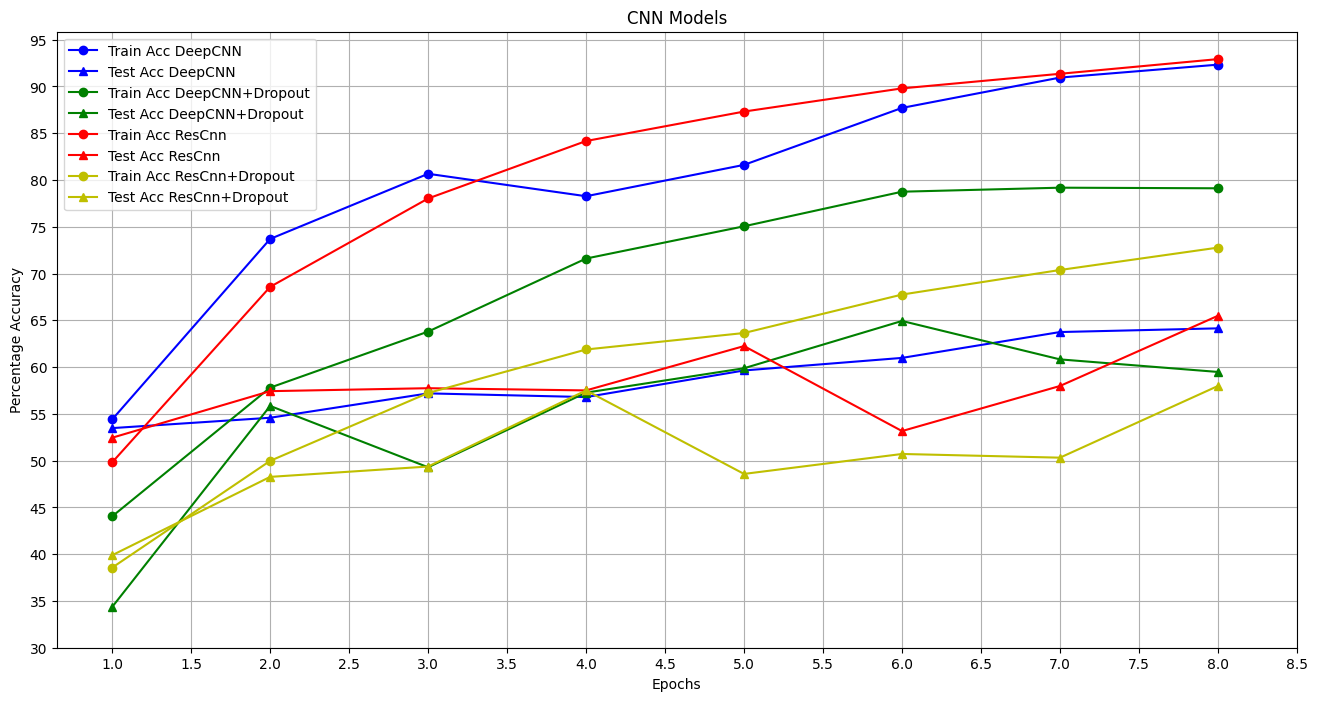

In [302]:
plt.figure(figsize=(16,8))
plt.plot(np.arange(1,9),train_accuracy_1,marker='o',c='b',label="Train Acc DeepCNN")
plt.plot(np.arange(1,9),test_accuracy_1,marker='^',c='b',label="Test Acc DeepCNN")
plt.plot(np.arange(1,9),train_accuracy_2,marker='o',c='g',label="Train Acc DeepCNN+Dropout")
plt.plot(np.arange(1,9),test_accuracy_2,marker='^',c='g',label="Test Acc DeepCNN+Dropout")
plt.plot(np.arange(1,9),train_accuracy_3,marker='o',c='r',label="Train Acc ResCnn")
plt.plot(np.arange(1,9),test_accuracy_3,marker='^',c='r',label="Test Acc ResCnn")
plt.plot(np.arange(1,9),train_accuracy_4,marker='o',c='y',label="Train Acc ResCnn+Dropout")
plt.plot(np.arange(1,9),test_accuracy_4,marker='^',c='y',label="Test Acc ResCnn+Dropout")
plt.legend()
plt.grid()
plt.title("CNN Models")
plt.xlabel("Epochs")
plt.ylabel("Percentage Accuracy")
plt.xticks(np.arange(1,9,0.5))
plt.yticks(np.arange(30,100,5))
plt.show()

In [303]:
from collections import Counter

def class_distribution(loader):
    counter = Counter()
    for _, labels in loader:
        counter.update(labels.cpu().numpy())
    return counter

print(class_distribution(train_loader))
print(class_distribution(test_loader))

Counter({np.int64(7): 2604, np.int64(6): 2578, np.int64(4): 2572, np.int64(3): 2563, np.int64(2): 2506, np.int64(1): 2496, np.int64(5): 2486, np.int64(0): 2459})
Counter({np.int64(1): 646, np.int64(0): 240, np.int64(2): 152, np.int64(4): 132, np.int64(3): 43, np.int64(7): 32, np.int64(6): 13, np.int64(5): 8})


In [304]:
#Metrics
from torchmetrics.classification import (MulticlassConfusionMatrix,MulticlassAccuracy,MulticlassPrecision,MulticlassRecall,
                                        MulticlassF1Score,MulticlassAUROC,MulticlassPrecisionRecallCurve)
def model_metrics(model,test_loader,num_classes):
    model.eval()
    correct=0
    total=0
    confusion_matrix=MulticlassConfusionMatrix(num_classes=num_classes).to(device)
    accuracy=MulticlassAccuracy(num_classes=num_classes).to(device)
    precision=MulticlassPrecision(num_classes=num_classes).to(device)
    recall=MulticlassRecall(num_classes=num_classes).to(device)
    f1score=MulticlassF1Score(num_classes=num_classes).to(device)
    auc=MulticlassAUROC(num_classes=num_classes,average="macro").to(device)
    pr_curve=MulticlassPrecisionRecallCurve(num_classes=num_classes).to(device)
    metrics=[confusion_matrix,accuracy,precision,recall,f1score,auc,pr_curve]
    with torch.no_grad():
        for x,y in test_loader:
            x,y=x.to(device),y.to(device)
            logits=model(x)
            probs=torch.softmax(logits,dim=1)
            pred=logits.argmax(dim=1)
            for metric in metrics:
                metric.update(logits,y)
            correct+=(pred==y).sum().item()
            total+=y.size(0)
            
    
    print("Accuracy :", 100*accuracy.compute().item())
    print("Precision:", 100*precision.compute().item())
    print("Recall   :", 100*recall.compute().item())
    print("F1-score :", 100*f1score.compute().item())
    print("Confusion Matrix:\n", confusion_matrix.compute().detach().cpu().numpy())
    print("AOC:",auc.compute().item())
    precision,recall,thresholds=pr_curve.compute()
    for i in range(num_classes):
        plt.plot(recall[i].detach().cpu().numpy(),precision[i].detach().cpu().numpy(),label=f"Class = {i}")
    plt.title("PR Curves")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    for metric in metrics:
                metric.reset()
    
    print(f"Raw Accuracy: {100*(correct/total) :.2f}")

Accuracy : 49.74115788936615
Precision: 52.973318099975586
Recall   : 49.74115788936615
F1-score : 50.38708448410034
Confusion Matrix:
 [[167  33  13   4  16   0   1   6]
 [100 452  31   2  57   1   1   2]
 [ 10   8 109   4  14   2   0   5]
 [  7   6  13  10   6   0   0   1]
 [ 30  21  15   3  58   0   0   5]
 [  0   1   3   0   0   4   0   0]
 [  0   3   3   0   0   0   7   0]
 [ 10   2   9   4   2   0   0   5]]
AOC: 0.8869491219520569
Raw Accuracy: 64.14


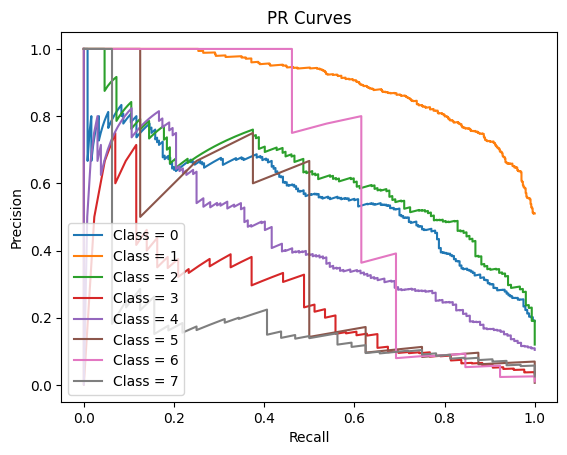

In [305]:
model_metrics(model1,test_loader,8)

Accuracy : 57.963693141937256
Precision: 46.128857135772705
Recall   : 57.963693141937256
F1-score : 49.604034423828125
Confusion Matrix:
 [[125  30  14  13  51   1   0   6]
 [ 99 420  31   5  71  10   3   7]
 [  7   7  85  18  17   3   2  13]
 [  2   1   7  23   6   0   0   4]
 [ 17  17   8  14  71   0   2   3]
 [  0   0   1   0   1   6   0   0]
 [  0   3   2   0   0   0   8   0]
 [  2   1   4   6   4   0   0  15]]
AOC: 0.8811367154121399
Raw Accuracy: 59.48


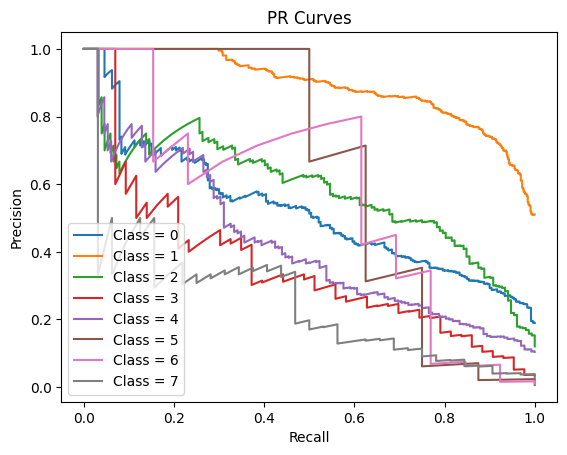

In [306]:
model_metrics(model2,test_loader,8)

Accuracy : 49.698129296302795
Precision: 48.781853914260864
Recall   : 49.698129296302795
F1-score : 48.445504903793335
Confusion Matrix:
 [[124  67  11   5  26   0   0   7]
 [ 54 526  12   1  39   4   2   8]
 [ 15  12  83   8  14   7   0  13]
 [  2   5  12  10  12   0   0   2]
 [ 23  24  10   5  62   1   1   6]
 [  0   3   1   0   0   3   0   1]
 [  0   4   0   0   1   0   8   0]
 [  5   2   9   0   3   0   0  13]]
AOC: 0.8870701789855957
Raw Accuracy: 65.48


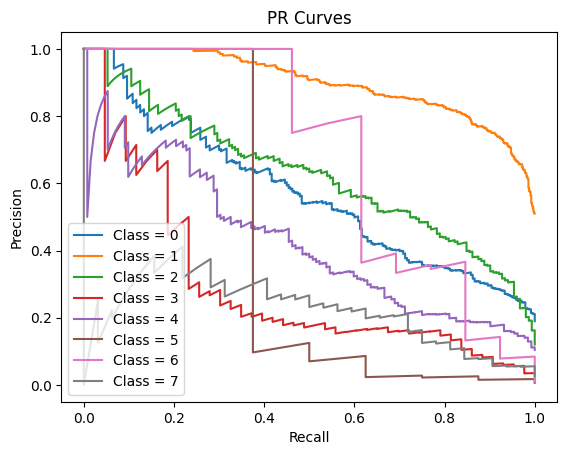

In [307]:
model_metrics(model3,test_loader,8)

Accuracy : 53.59727740287781
Precision: 47.42124676704407
Recall   : 53.59727740287781
F1-score : 47.8390246629715
Confusion Matrix:
 [[ 66  53  22  27  61   1   0  10]
 [ 44 457  39  15  83   2   1   5]
 [  1   6  87  27  12   5   0  14]
 [  1   1   8  25   7   0   0   1]
 [ 11  13  15  17  73   0   1   2]
 [  0   0   1   1   1   4   0   1]
 [  0   3   1   0   0   0   9   0]
 [  2   0   6   8   2   1   0  13]]
AOC: 0.8824692964553833
Raw Accuracy: 57.98


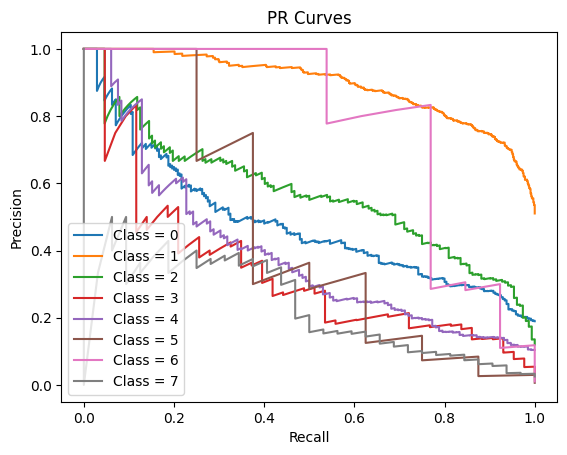

In [308]:
model_metrics(model4,test_loader,8)